In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment

In [10]:
def euclidean_distance_matrix(set_a: np.ndarray, set_b: np.ndarray):
    """Computes the Euclidean distance matrix between two sets of points.

    Args:
        set_a (np.ndarray): points in set A
        set_b (np.ndarray): points in set B

    Returns:
        np.ndarray: distance matrix
    """
    dist_matrix = np.zeros((len(set_a), len(set_b)))
    for i, point_a in enumerate(set_a):
        for j, point_b in enumerate(set_b):
            dist_matrix[i, j] = np.linalg.norm(point_a - point_b)
    return dist_matrix


def compute_matches(data1: np.ndarray, data2: np.ndarray, 
                    d_max: float = None, weighted: bool = False, 
                    microns: np.ndarray = None,
                    debug: bool = True) -> tuple:
    """ Compute metrics for matching points between two arrays.

    Args:
        data1 (np.ndarray): array of points
        data2 (np.ndarray): array of points
        d_max (float, optional): maximum distance tolerance for two matching points. Defaults to None.
        weighted (bool, optional): use weighted accuracy. Defaults to False.
        microns (np.ndarray, optional): microns per pixel for each axis. Defaults to None.
        debug (bool, optional): print debug information. Defaults to True.
        
    Returns:
        tuple: mean_distance, median_distance, rmse, max_distance, overall_accuracy
    """
    if microns is not None:
        data1 = np.copy(data1) * np.array(microns)
        data2 = np.copy(data2) * np.array(microns)
    
    distance_matrix = euclidean_distance_matrix(data1, data2)
    row_ind, col_ind = linear_sum_assignment(distance_matrix)
    
    # Extract the distances for the optimal matches
    matched_distances = distance_matrix[row_ind, col_ind]

    # Calculate distances
    mean_distance = np.mean(matched_distances)
    median_distance = np.median(matched_distances)

    # Calculate RMSE
    rmse = np.sqrt(np.mean(matched_distances ** 2))

    # Calculate maximum distance
    max_distance = np.max(matched_distances)

    # Print the results
    if debug:
        unit = "px" if microns is None else "µm"
        print(f"Mean distance: {mean_distance} {unit}")
        print(f"Median distance: {median_distance} {unit}")
        print(f"RMSE: {rmse}")
        print(f"Maximum distance: {max_distance} {unit}")
    
    # If d_max is given
    if d_max is not None:
        
        if not weighted:
            # Initialize an array for accuracies
            accuracies = np.zeros_like(matched_distances)

            # Compute accuracy for each matched pair
            for i, distance in enumerate(matched_distances):
                if distance <= d_max:
                    #normalized_distance = distance / d_max
                    accuracies[i] = 1
                else:
                    accuracies[i] = 0  # Assign 0% accuracy for distances greater than d_max
        else:
        # Calculate normalized distances and convert to accuracy percentage
            normalized_distances = np.clip(matched_distances / d_max, 0, 1)
            accuracies = (1 - normalized_distances)
        #print(accuracies)

        # Calculate overall accuracy
        overall_accuracy = np.mean(accuracies)

        # Print the results
        if debug:
            print(f"Overall accuracy: {overall_accuracy}")
        return mean_distance, median_distance, rmse, max_distance, overall_accuracy
        
    return mean_distance, median_distance, rmse, max_distance

In [29]:
# Define data paths
input_points_path = "../Matches/B0070/input/inputpoints.txt"
gt_points_path = "../Matches/B0070/gt/240716_AS_manual labeling for B70 section 100_ contast 0.3_PG.txt"

# Other variables
IDX = 280 - 100

# Read in data
data = np.loadtxt(input_points_path, skiprows=2)
gt = np.loadtxt(gt_points_path, skiprows=2)

# Process data
data = data[data[:, 0] == IDX]
data = data[:, 1:]
gt = gt[:, 1:]
microns_per_pixel = (1.25, 1.25)

# Print statistics
print("Number of points in data:", data.shape[0])
print("Number of points in gt:", gt.shape[0])
print("Microns per pixel:", microns_per_pixel)
print()

stats = compute_matches(data, gt, d_max=250, microns=None)

Number of points in data: 918
Number of points in gt: 1272
Microns per pixel: (1.25, 1.25)

Mean distance: 169.0830584710746 px
Median distance: 2.805383824859673 px
RMSE: 489.4498413441534
Maximum distance: 2498.539709484563 px
Overall accuracy: 0.8649237472766884


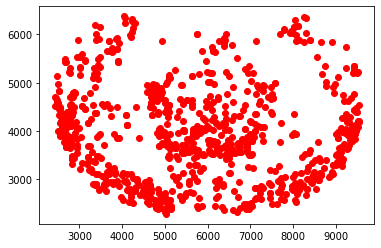

In [30]:
plt.scatter(data[:, 1], data[:, 0], c='r', label='Data')
plt.show()

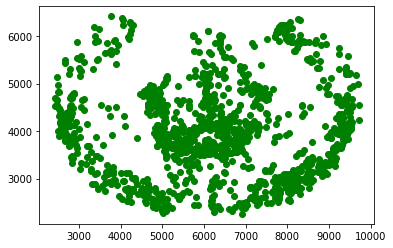

In [33]:
plt.scatter(gt[:, 1], gt[:, 0], c='g', label='Data')
plt.show()

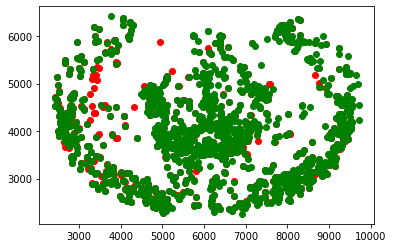

In [32]:
plt.scatter(data[:, 1], data[:, 0], c='r', label='Data')
plt.scatter(gt[:, 1], gt[:, 0], c='g', label='Data')
plt.show()